Hate Speech Detector using Bert based model

# Setup

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import warnings

# plotting
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style("whitegrid")

from sklearn.model_selection import train_test_split

In [ ]:
# Mount google drive, make sure the filesystem is coherent with the notebook's

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Disable Warnings

In [ ]:
def fxn():
    warnings.warn("deprecated", DeprecationWarning)

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    fxn()

## Install

In [ ]:
!pip install -qq transformers
!pip install watermark

%reload_ext watermark
%watermark -v -p numpy,pandas,torch,transformers

import transformers
from transformers import BertModel, BertConfig, BertForSequenceClassification, BertTokenizer, AdamW, get_linear_schedule_with_warmup
from transformers import XLNetModel, XLNetTokenizer, XLNetForSequenceClassification
from transformers import AutoModel, AutoTokenizer 
import torch
import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from collections import defaultdict
from textwrap import wrap
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
%matplotlib inline
%config InlineBackend.figure_format='retina'
sns.set(style='whitegrid', palette='muted', font_scale=1.2)

HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]
sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))
rcParams['figure.figsize'] = 12, 8
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

     |████████████████████████████████| 3.4 MB 14.6 MB/s 
     |████████████████████████████████| 895 kB 60.0 MB/s 
     |████████████████████████████████| 67 kB 6.4 MB/s 
     |████████████████████████████████| 3.3 MB 46.4 MB/s 
     |████████████████████████████████| 596 kB 65.7 MB/s 
  Attempting uninstall: importlib-metadata
    Found existing installation: importlib-metadata 4.10.0
    Uninstalling importlib-metadata-4.10.0:
      Successfully uninstalled importlib-metadata-4.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
markdown 3.3.6 requires importlib-metadata>=4.4; python_version < "3.10", but you have importlib-metadata 2.1.2 which is incompatible.
Python implementation: CPython
Python version       : 3.7.12
IPython version      : 5.5.0

numpy       : 1.19.5
pandas      : 1.1.5
torch       : 1.10.0+cu111
transformers: 4.15.0



## Data Loading and Formatting

In [ ]:
# Load Dataset 9 - Twitter 2017 with 24 802 tweets
# https://github.com/t-davidson/hate-speech-and-offensive-language

# Make sure the file system is coherent
PATH_DATASETS = 'drive/MyDrive/Hate Speech TikTok/datasets' 
DATASET = 'merged'
data_df = pd.read_csv(f'{PATH_DATASETS}/{DATASET}.csv')
class_names = ['Hate Speech', 'Offensive or not Hate Speech']

#data_df = pd.read_json (f'{PATH_DATASETS}/HateXplain.json')

In [ ]:
data_df.head()

,Unnamed: 0,text,target
0,0,!!! RT @mayasolovely: As a woman you shouldn't...,1
1,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...,1
2,2,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...,1
3,3,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...,1
4,4,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...,1


In [ ]:
from sklearn.model_selection import train_test_split

# For reproductibility
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

# Make train data
train_df, test_df = train_test_split(
  data_df,
  test_size=0.05,
  random_state=RANDOM_SEED
)

print(train_df.shape, test_df.shape)

(88270, 3) (4646, 3)


# Cleaning text

## Pre-processing cleaning

We remove :

*   non string data
*   we put all in lower case
*   mentions and e-mails
*   URLS
*   Numerical data
*   Puncutations
*   Useless spaces
*   'RT' words



In [ ]:
# We remove garbage noise such as useless punctuation symbols, RT, mentions (@username)
import re

def clean_tweet(tweet) :
  if not isinstance(tweet, str) :
    return 'DATA TO REMOVE'
  lower_cased = tweet.lower() # Put in lower case for easier processing
  removed_mentions_email = re.sub('[^ ]?@[^ ]*', '', lower_cased) # Remove mentions and e-mails
  
  url_pattern = re.compile(r'https?://\S+|www\.\S+') # find urls
  removed_urls = url_pattern.sub(r'', removed_mentions_email) # Removes urls
  
  removed_numbers = re.sub('[0-9]', '', removed_urls) # Remove numerical data
  removed_punc = re.sub('[^a-zA-Z ]*', '', removed_numbers) # Remove punctuations
  removed_trailing_spaces = re.sub(' +', ' ', removed_punc).strip() # Removes useless spaces 

  removed_rt = re.sub(' rt ', ' ', removed_trailing_spaces) # Remove 'RT' words in middle of texts
  splitted = removed_rt.split(' ', 1) # = [first word, rest of tweet]
  if splitted[0] == 'rt' : # We remove the rt at beggining of the text (first word)
    try : 
      cleaned_tweet = splitted[1]
    except IndexError : # This means the tweet is smthg like "rt USERNAME". It's useless we can remove it
      cleaned_tweet = 'DATA TO REMOVE'
  else :
    cleaned_tweet = removed_rt
  
  return cleaned_tweet

train_df['text'] = train_df['text'].apply(lambda x: clean_tweet(x))
train_df = train_df[train_df['text'] != 'DATA TO REMOVE']
test_df['text'] = test_df['text'].apply(lambda x: clean_tweet(x))
test_df = test_df[test_df['text'] != 'DATA TO REMOVE']
train_df.head()

,Unnamed: 0,text,target
47732,17946,only whites and east asians create cultures wh...,1
88169,30437,bihday to princephilip do you like this new of...,1
18670,18670,wtf is boy pussy lmao you atl nigga sick,1
10424,10424,i hate chunky pasta sauce keep pesky vegetable...,1
11890,11890,it doesnt just affect kids it affects the facu...,1


In [ ]:
import re
from nltk.tokenize import word_tokenize 
from wordcloud import WordCloud, STOPWORDS
import spacy

import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
nlp = spacy.load('en', disable=['parser', 'ner'])

We keep the lower and upper cases because it can have an impact on the sentiment.
Removing the ponctuation was also not efficient.

After some transformation, the reviews are much cleaner, but we still have some words that we should remove, namely the stopwords. Stopwords are commonly used words (i.e. “the”, “a”, “an”) that do not add meaning to a sentence and can be ignored without having a drastic effect on the meaning of the sentence.


In [ ]:
stop = stopwords.words('english')

train_df['text'] = train_df['text'].apply(lambda x: " ".join(x for x in x.split() if x not in stop))
test_df['text'] = test_df['text'].apply(lambda x: " ".join(x for x in x.split() if x not in stop))

Lastly, we will implement lemmatization using Spacy so that we can count the appearance of each word. Lemmatization removes the grammar tense and transforms each word into its original form. Another way of converting words to its original form is called stemming. While stemming takes the linguistic root of a word, lemmatization is taking a word into its original lemma. For example, if we performed stemming on the word “apples”, the result would be “appl”, whereas lemmatization would give us “apple”. Therefore I prefer lemmatization over stemming, as its much easier to interpret.

In [ ]:
def space(comment):
    doc = nlp(comment)
    return " ".join([token.lemma_ for token in doc])

train_df['text']= train_df['text'].apply(space)
test_df['text']= test_df['text'].apply(space)

In [ ]:
train_df.head()

,Unnamed: 0,text,target
47732,17946,whites east asians create culture jews destroy...,1
88169,30437,bihday princephilip like new official porait,1
18670,18670,wtf boy pussy lmao atl nigga sick,1
10424,10424,hate chunky pasta sauce keep pesky vegetable way,1
11890,11890,do not affect kid affect faculty staff work sc...,1


## Spell Checker

gave up bcs it takes too much long time

In [ ]:
if False :
  !pip install pyspellchecker
  from spellchecker import SpellChecker

  spell = SpellChecker()
  def correct_spellings(text):
      corrected_text = []
      misspelled_words = spell.unknown(text.split())
      for word in text.split():
          if word in misspelled_words:
              corrected_text.append(spell.correction(word))
          else:
              corrected_text.append(word)
      return " ".join(corrected_text)

  text = "speling correctin"
  print(correct_spellings(text))
  text = "thnks for readin the notebook"
  print(correct_spellings(text))

  train_df['text']= train_df['text'].apply(correct_spellings)
  test_df['text']= test_df['text'].apply(correct_spellings)

## Handling words with multiple repetition letters

In [ ]:
def repetition(text):
    return re.sub("(.)\\1{3,}", "\\1", text)

train_df['text']= train_df['text'].apply(repetition)
test_df['text']= test_df['text'].apply(repetition)

## Chat Words Conversion

In [ ]:
chat_words_str = """
AFAIK=As Far As I Know
AFK=Away From Keyboard
ASAP=As Soon As Possible
ATK=At The Keyboard
ATM=At The Moment
A3=Anytime, Anywhere, Anyplace
BAK=Back At Keyboard
BBL=Be Back Later
BBS=Be Back Soon
BFN=Bye For Now
B4N=Bye For Now
BRB=Be Right Back
BRT=Be Right There
BTW=By The Way
B4=Before
B4N=Bye For Now
CU=See You
CUL8R=See You Later
CYA=See You
FAQ=Frequently Asked Questions
FC=Fingers Crossed
FWIW=For What It's Worth
FYI=For Your Information
GAL=Get A Life
GG=Good Game
GN=Good Night
GMTA=Great Minds Think Alike
GR8=Great!
G9=Genius
IC=I See
ICQ=I Seek you (also a chat program)
ILU=ILU: I Love You
IMHO=In My Honest/Humble Opinion
IMO=In My Opinion
IOW=In Other Words
IRL=In Real Life
KISS=Keep It Simple, Stupid
LDR=Long Distance Relationship
LMAO=Laugh My fuck Off
LOL=Laughing Out Loud
LTNS=Long Time No See
L8R=Later
MTE=My Thoughts Exactly
M8=Mate
NRN=No Reply Necessary
OIC=Oh I See
PITA=Pain In The fuck
PRT=Party
PRW=Parents Are Watching
ROFL=Rolling On The Floor Laughing
ROFLOL=Rolling On The Floor Laughing Out Loud
ROTFLMAO=Rolling On The Floor Laughing My fuck Off
SK8=Skate
STATS=Your sex and age
ASL=Age, Sex, Location
THX=Thank You
TTFN=Ta-Ta For Now!
TTYL=Talk To You Later
U=You
U2=You Too
U4E=Yours For Ever
WB=Welcome Back
WTF=What The fuck
WTG=Way To Go!
WUF=Where Are You From?
WKDN=Week-End
W8=Wait...
7K=Sick Laugher
"""

chat_words_map_dict = {}
chat_words_list = []
for line in chat_words_str.split("\n"):
    if line != "":
        cw = line.split("=")[0]
        cw_expanded = line.split("=")[1]
        chat_words_list.append(cw)
        chat_words_map_dict[cw] = cw_expanded
chat_words_list = set(chat_words_list)

def chat_words_conversion(text):
    new_text = []
    for w in text.split():
        if w.upper() in chat_words_list:
            new_text.append(chat_words_map_dict[w.upper()])
        else:
            new_text.append(w)
    return " ".join(new_text)

print(chat_words_conversion("one minute BRB"))

train_df['text']= train_df['text'].apply(chat_words_conversion)
test_df['text']= test_df['text'].apply(chat_words_conversion)

one minute Be Right Back


# Data Exploration

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


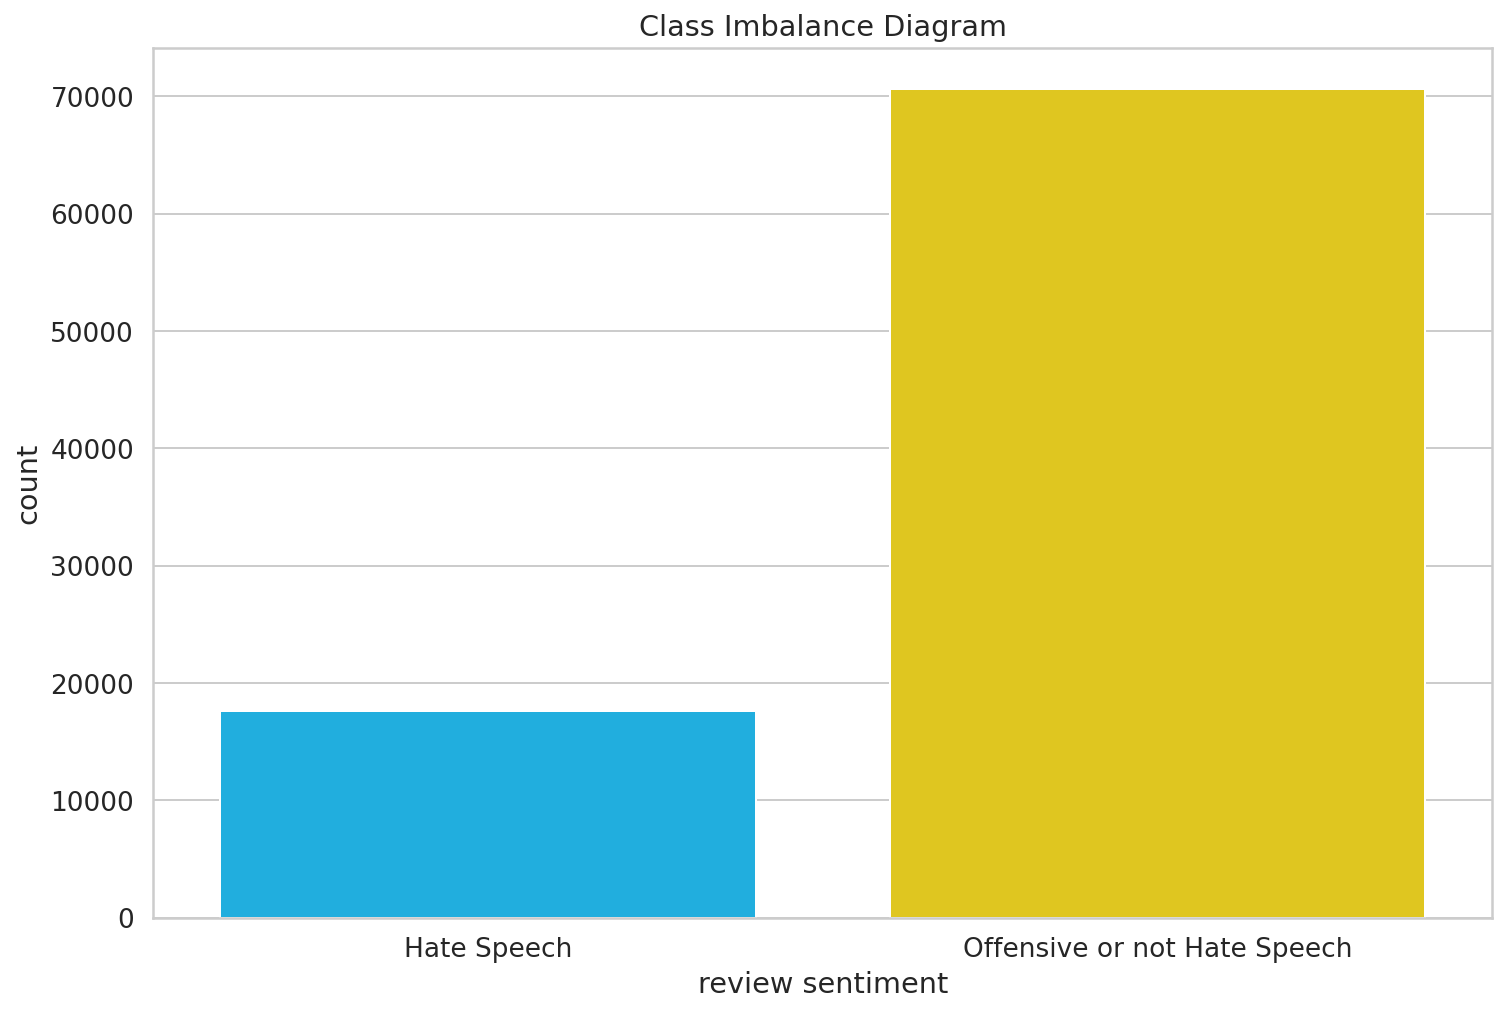

In [ ]:
ax = sns.countplot(train_df.target)
plt.xlabel('review sentiment')
plt.title('Class Imbalance Diagram')
ax.set_xticklabels(class_names);

## Other visualizations

In [ ]:
def get_length_alphabets(text):
    text = str(text)
    return len(text)

In [ ]:
def get_length_words(text):
    text = str(text)
    return len(text.split(' '))

In [ ]:
train_df['length_alphabets'] = train_df['text'].apply(lambda x: get_length_alphabets(x))
train_df['length_words'] = train_df['text'].apply(lambda x: get_length_words(x))
train_df.head()

,Unnamed: 0,text,target,length_alphabets,length_words
47732,17946,whites east asians create culture jews destroy...,1,81,12
88169,30437,bihday princephilip like new official porait,1,44,6
18670,18670,What The fuck boy pussy Laugh My fuck Off atl ...,1,56,12
10424,10424,hate chunky pasta sauce keep pesky vegetable way,1,48,8
11890,11890,do not affect kid affect faculty staff work sc...,1,56,10


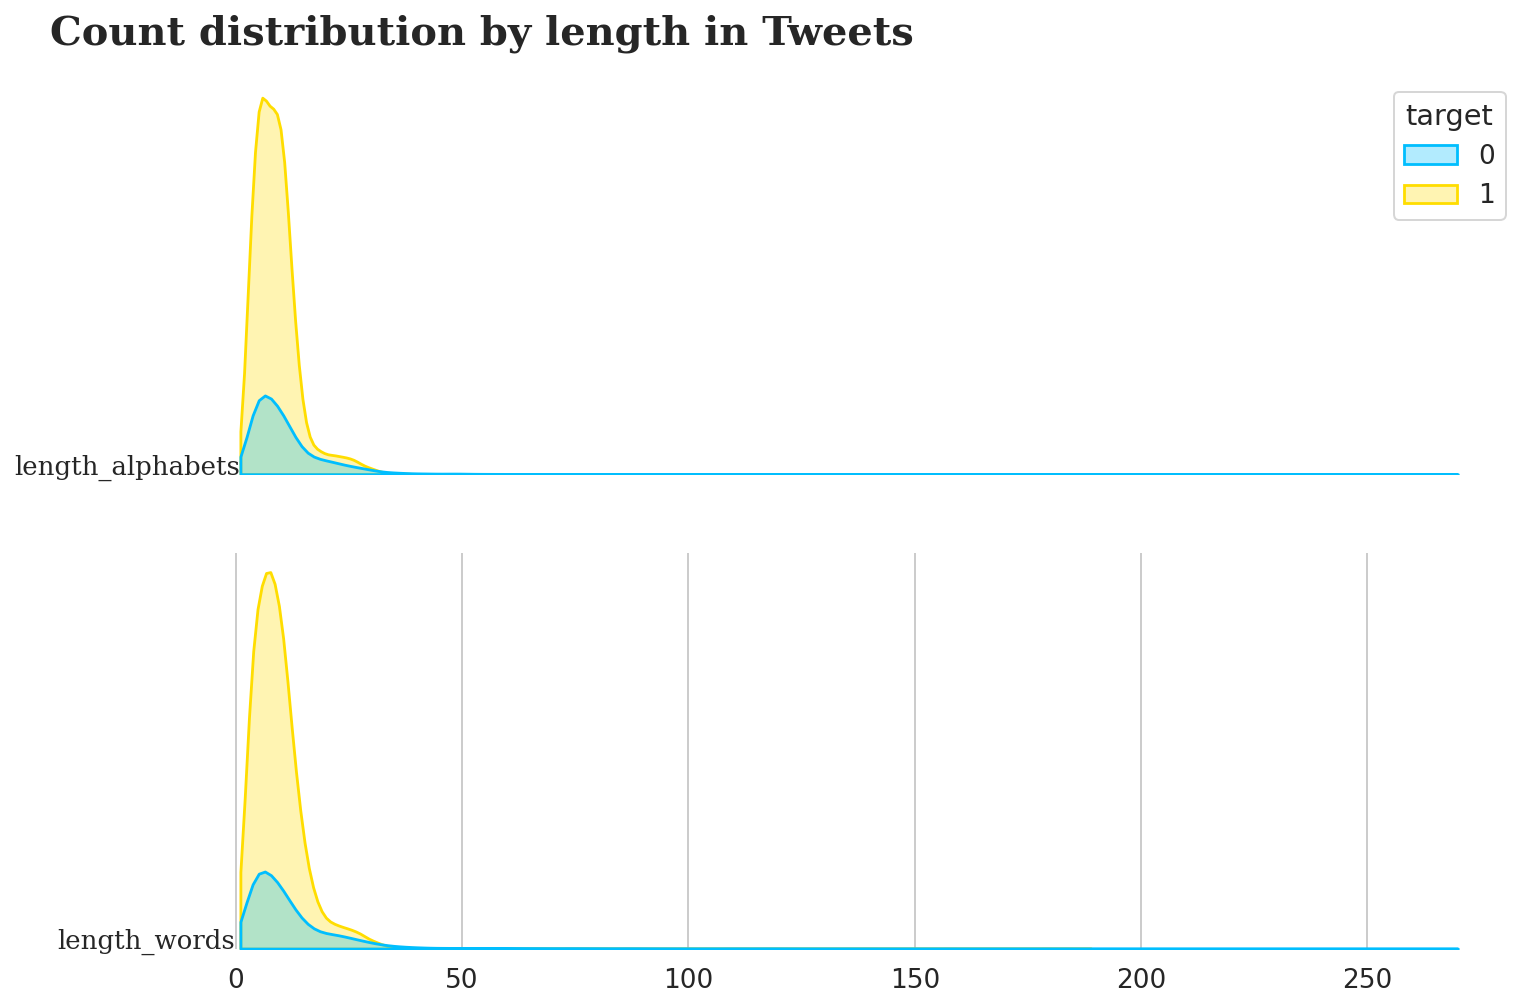

In [ ]:
fig = plt.figure(figsize=(12, 8))
gs = fig.add_gridspec(2,1)

axes = list()

for index, data in zip(range(2), train_df):
    axes.append(fig.add_subplot(gs[index, 0]))
    
    
    if index==0:
        sns.kdeplot(x='length_alphabets', data=train_df, 
                        fill=True, ax=axes[index], cut=0, bw_method=0.20, 
                        lw=1.4 , hue='target',
                         alpha=0.3)
    else:
        sns.kdeplot(x='length_words', data=train_df, 
                    fill=True, ax=axes[index], cut=0, bw_method=0.20, 
                    lw=1.4 , hue='target',
                     alpha=0.3) 

    axes[index].set_yticks([])
    if index != 1 : axes[index].set_xticks([])
    axes[index].set_ylabel('')
    axes[index].set_xlabel('')
    for border in ['top', 'right', 'left', 'bottom'] :
      axes[index].spines[border].set_visible(False)    
    
    if index == 0:
        axes[index].text(-0.2,0,"length_alphabets",fontweight="light", fontfamily='serif', fontsize=13,ha="right")
    else:
        axes[index].text(-0.2,0,"length_words",fontweight="light", fontfamily='serif', fontsize=13,ha="right")
        
        
    axes[index].patch.set_alpha(0)
    if index != 0 : axes[index].get_legend().remove()
        
fig.text(0.05,0.91,"Count distribution by length in Tweets", fontweight="bold", fontfamily='serif', fontsize=20)
plt.show()

In [ ]:
def get_top_tweet_bigrams(corpus, n=None):
    vec = CountVectorizer(ngram_range=(2, 2)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

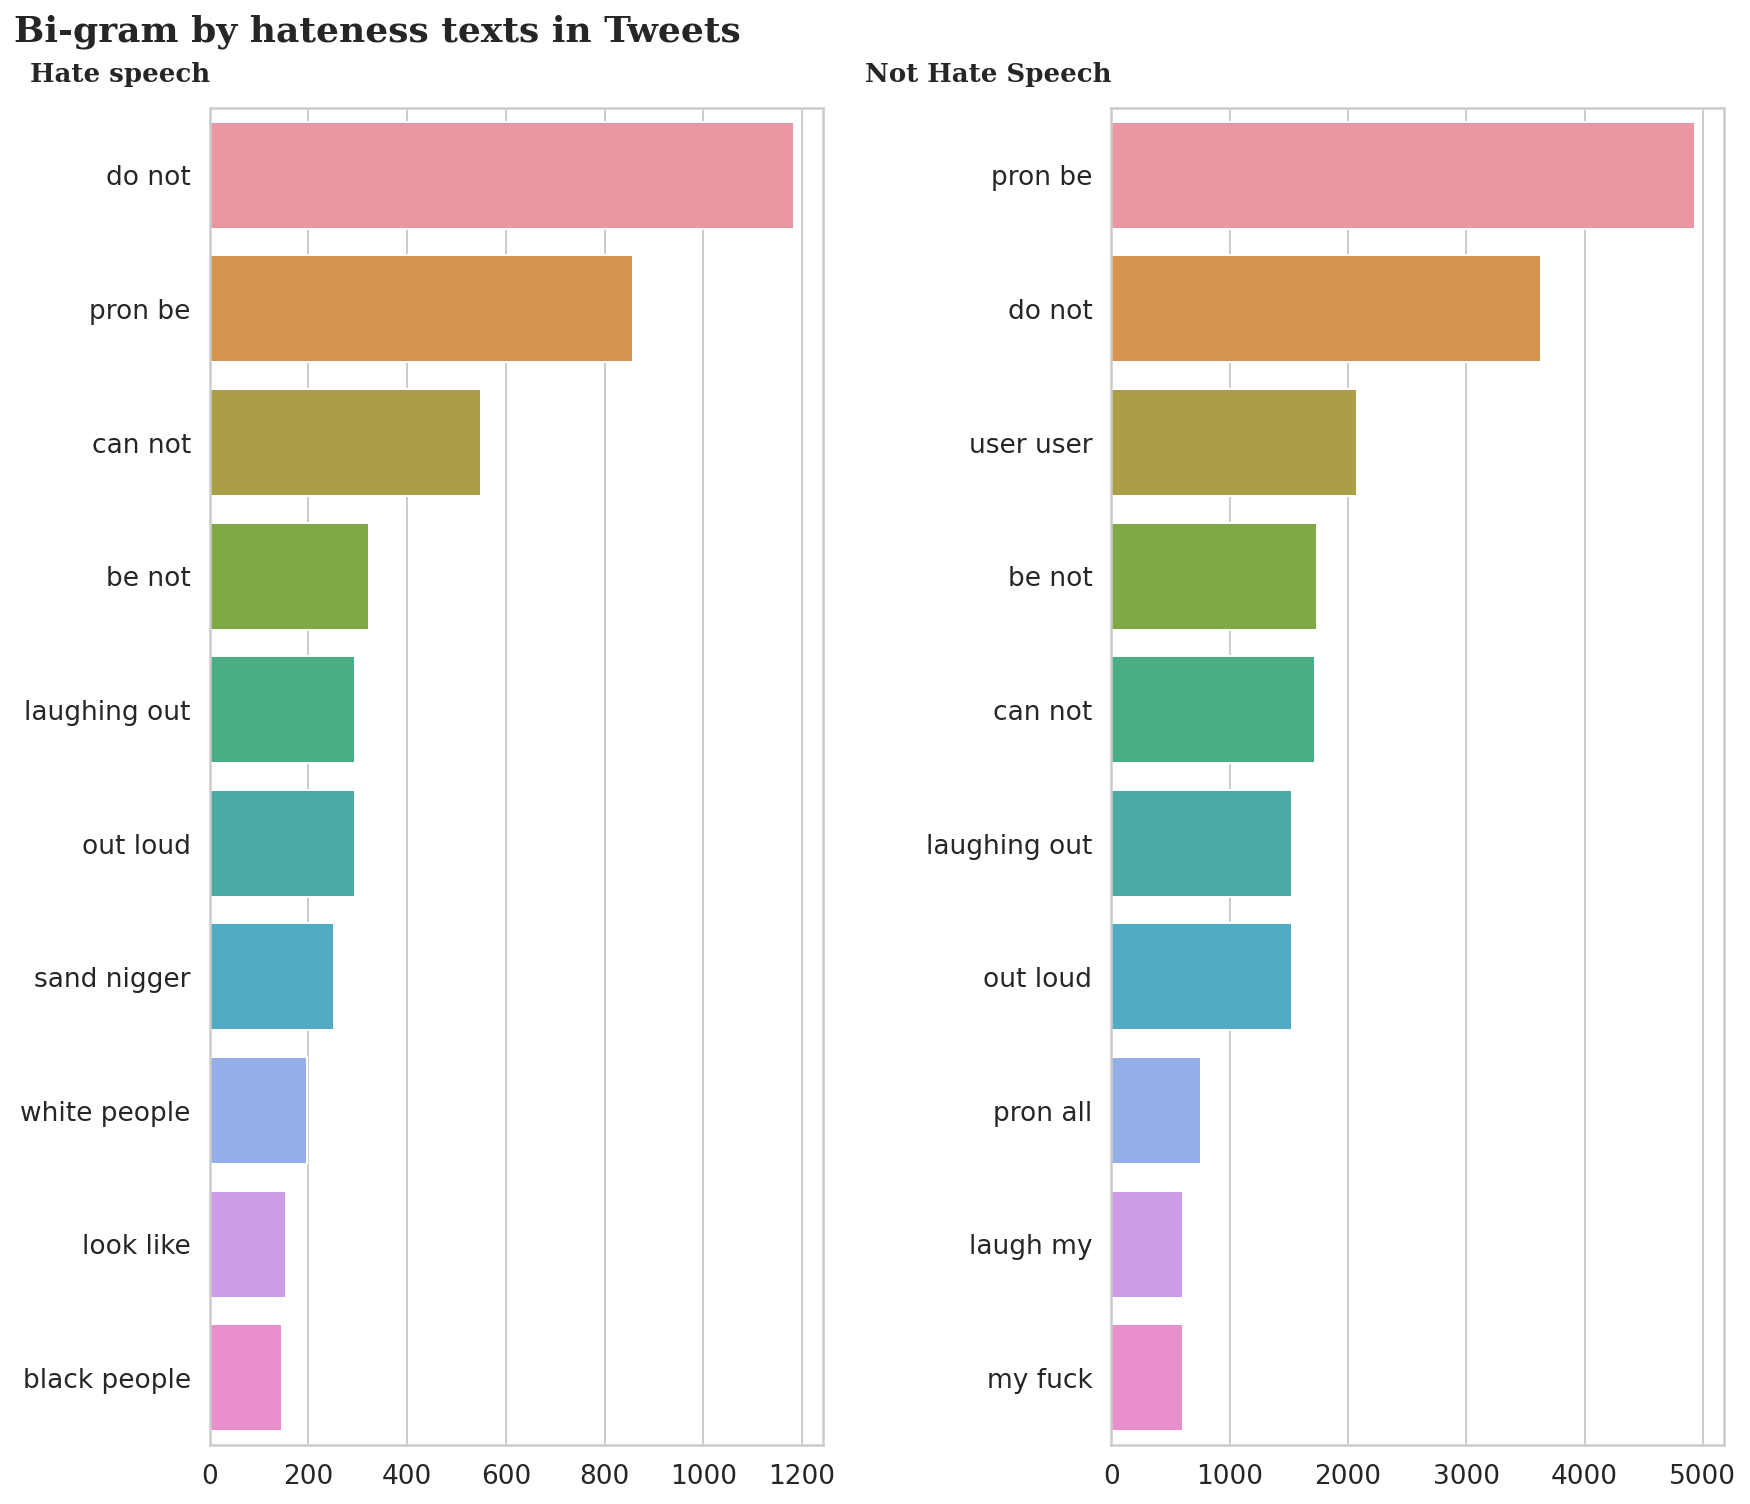

In [ ]:
fig, axes = plt.subplots(1,2, figsize=(12, 10), constrained_layout=True)

sentiment_list = list(np.unique(train_df['target']))

for i, sentiment in zip(range(3), sentiment_list):
    top_tweet_bigrams = get_top_tweet_bigrams(train_df[train_df['target']==sentiment]['text'].fillna(" "))[:10]
    x,y = map(list,zip(*top_tweet_bigrams))
    sns.barplot(x=y, y=x, ax=axes[i])
    axes[i].text(0,-0.7, "Hate speech" if sentiment == 0 else "Not Hate Speech", fontweight="bold", fontfamily='serif', fontsize=13,ha="right")
    axes[i].patch.set_alpha(0)

fig.text(0,1.01,"Bi-gram by hateness texts in Tweets", fontweight="bold", fontfamily='serif', fontsize=18)
plt.show()

In [ ]:
# Word Cloud

from PIL import Image
PATH_MASK = '/content/drive/MyDrive/Hate Speech TikTok/utils'
mask_dir = np.array(Image.open(f'{PATH_MASK}/twitter_mask.png'))

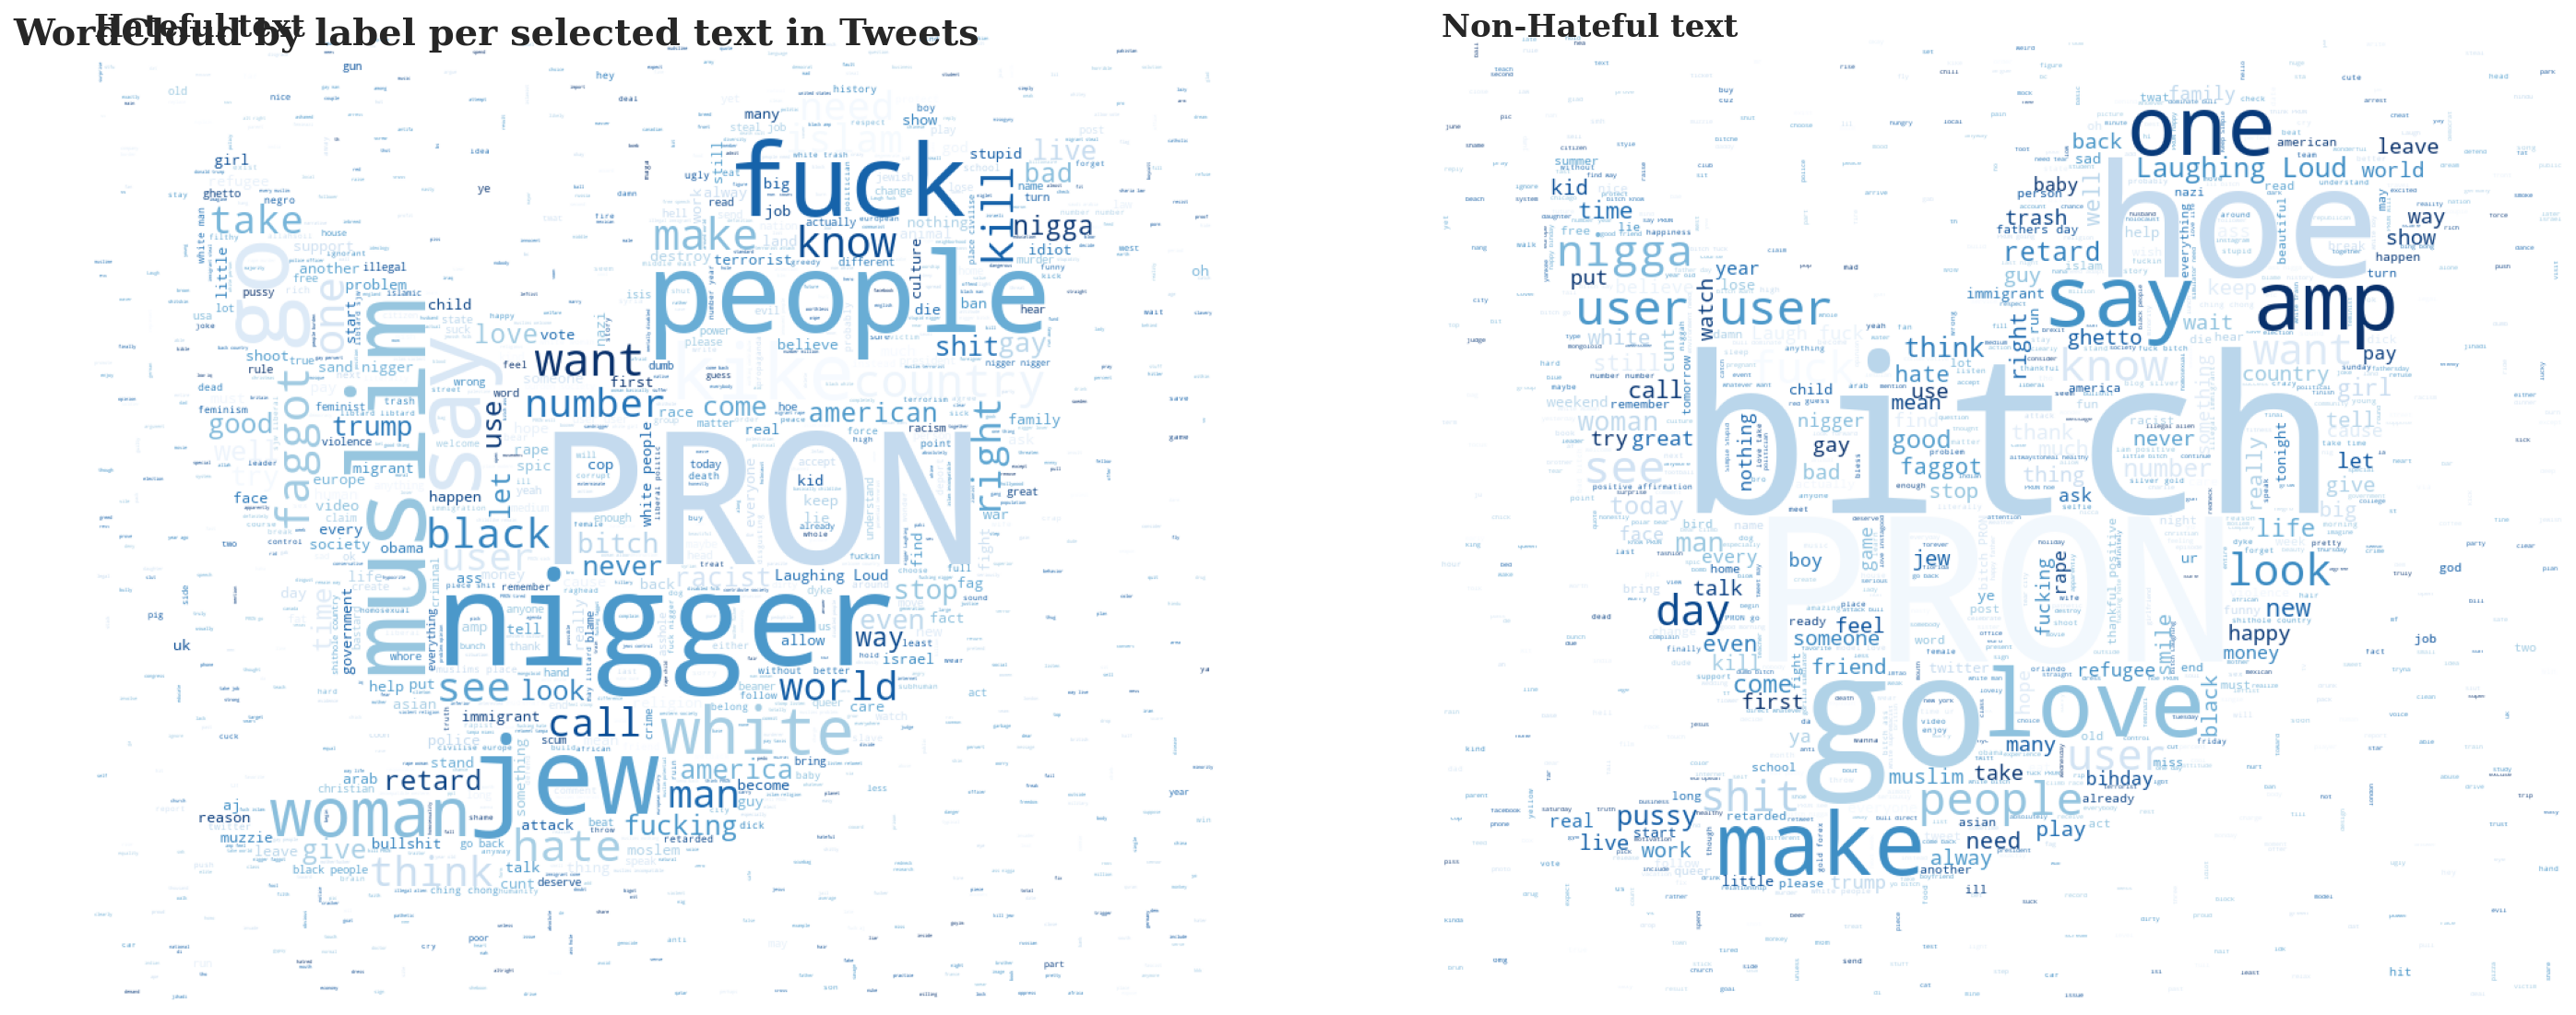

In [ ]:
from wordcloud import WordCloud

fig, axes = plt.subplots(1,2, figsize=(24,12))
label_list = list(np.unique(data_df['target']))

for i, target in enumerate(label_list):
    wc = WordCloud(background_color="white", max_words = 2000, width = 1600, 
                   height = 800, mask=mask_dir, colormap="Blues") \
                  .generate(" ".join(train_df[train_df['target']==target]['text']))
    label_str = "Hateful text" if target == 0 else "Non-Hateful text"
    axes[i].text(0.5,1, label_str, fontweight="bold", fontfamily='serif', fontsize=17)
    axes[i].patch.set_alpha(0)
    axes[i].axis('off')
    axes[i].imshow(wc)

fig.text(0.1,0.8,"WordCloud by label per selected text in Tweets", fontweight="bold", fontfamily='serif', fontsize=20)
plt.show()

In [ ]:
del train_df['length_alphabets'], train_df['length_words']
train_df.head()

,Unnamed: 0,text,target
47732,17946,whites east asians create culture jews destroy...,1
88169,30437,bihday princephilip like new official porait,1
18670,18670,What The fuck boy pussy Laugh My fuck Off atl ...,1
10424,10424,hate chunky pasta sauce keep pesky vegetable way,1
11890,11890,do not affect kid affect faculty staff work sc...,1


# Data Preprocessing

## Pretrained models list : https://huggingface.co/transformers/pretrained_models.html

You can use a cased and uncased version of BERT and tokenizer. I’ve experimented with both. The uncased version seems to work better.

## Load Tokenizer

In [ ]:
#PRE_TRAINED_MODEL_NAME = 'bert-base-cased'
PRE_TRAINED_MODEL_NAME = "Hate-speech-CNERG/bert-base-uncased-hatexplain-rationale-two"

In [ ]:
tokenizer = AutoTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

Downloading:   0%|          | 0.00/299 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/790 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

## Choosing Sequence Length

In [ ]:
token_lens = []

#for txt in train_df.text:
for txt in train_df.text:
  tokens = tokenizer.encode(txt, max_length=512)
  token_lens.append(len(tokens))

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


In [ ]:
max(token_lens)

383

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


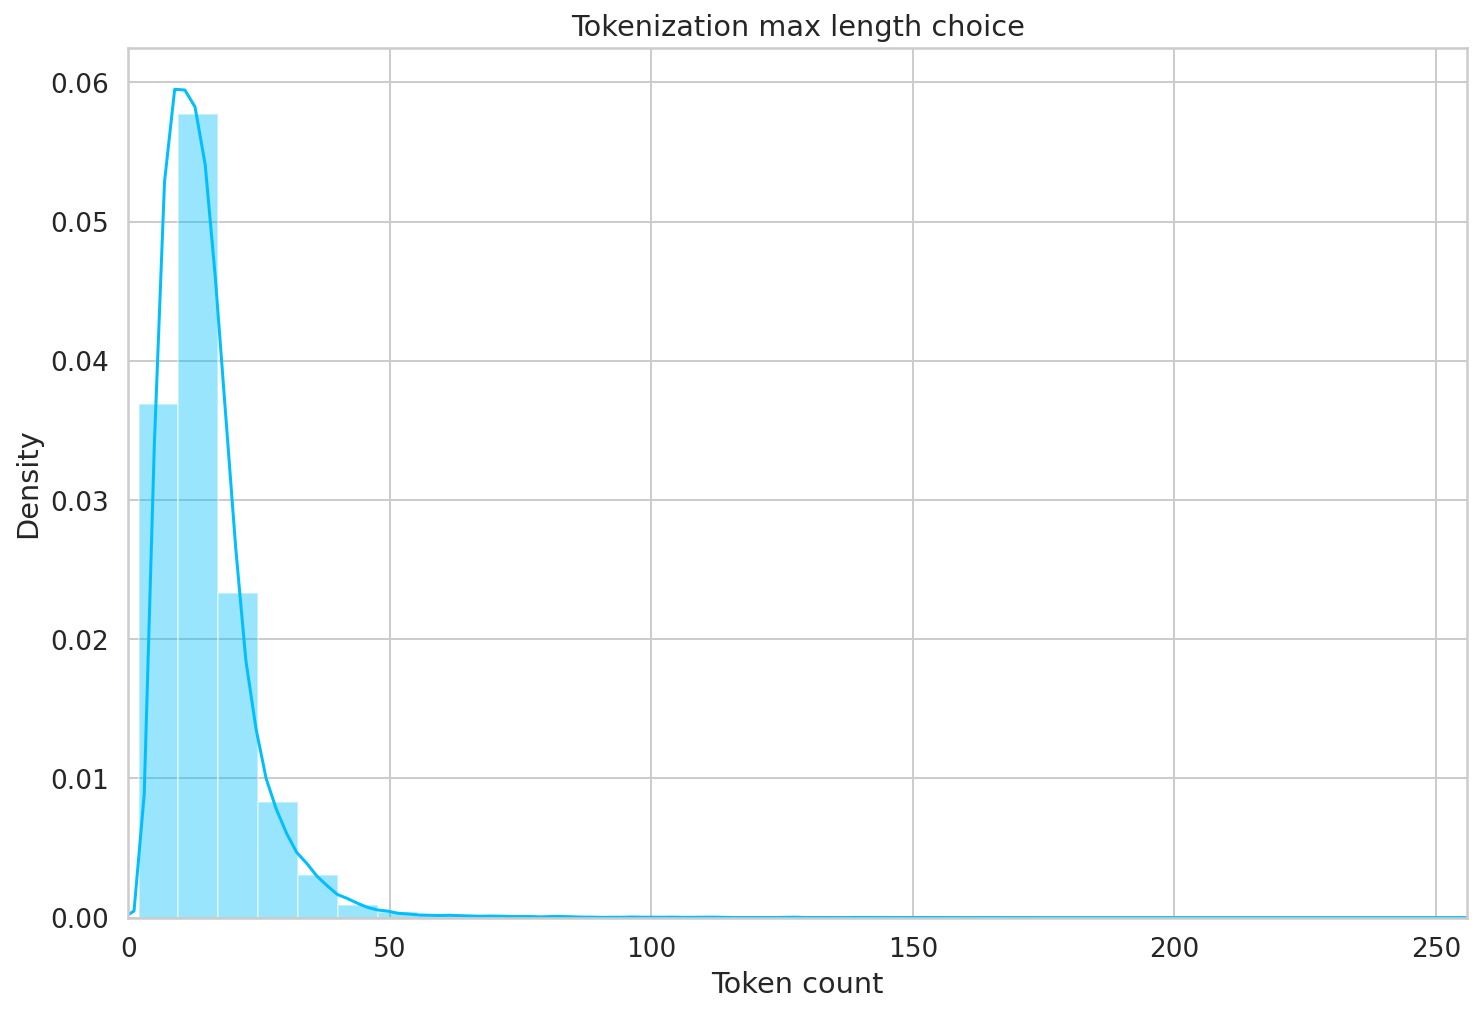

In [ ]:
sns.distplot(token_lens)
plt.xlim([0, 256]);
plt.xlabel('Token count');
plt.title('Tokenization max length choice')
plt.show()

In [ ]:
MAX_LEN = 100

## Create Datasets

From the entire dataset, we create


*   Training dataset
*   Validation dataset
*   Testing dataset
*   Prediction dataset (benchmark)



In [ ]:
class GPReviewDataset(Dataset):
  def __init__(self, reviews, targets, tokenizer, max_len):
    self.reviews = reviews
    self.targets = targets
    self.tokenizer = tokenizer
    self.max_len = max_len
  def __len__(self):
    return len(self.reviews)
  def __getitem__(self, item):
    review = str(self.reviews[item])
    target = self.targets[item]
    encoding = self.tokenizer.encode_plus(
      review,
      add_special_tokens=True,
      max_length=self.max_len,
      return_token_type_ids=False,
      pad_to_max_length=True,
      return_attention_mask=True,
      return_tensors='pt',
    )
    return {
      'review_text': review,
      'input_ids': encoding['input_ids'].flatten(),
      'attention_mask': encoding['attention_mask'].flatten(),
      'targets': torch.tensor(target, dtype=torch.long)
    }

In [ ]:
df_train, df_test = train_test_split(
  train_df,
  test_size=0.05,
  random_state=RANDOM_SEED
)
df_val, df_test = train_test_split(
  df_test,
  test_size=0.5,
  random_state=RANDOM_SEED
)

print(df_train.shape, df_test.shape, df_val.shape)

(83854, 3) (2207, 3) (2207, 3)


In [ ]:
def create_data_loader(df, tokenizer, max_len, batch_size):
  ds = GPReviewDataset(
    #reviews=df.text.to_numpy(),
    reviews=df.text.to_numpy(),
    targets=df.target.to_numpy(),
    tokenizer=tokenizer,
    max_len=max_len
  )
  return DataLoader(
    ds,
    batch_size=batch_size,
    num_workers=2
  )

In [ ]:
BATCH_SIZE = 16 # originally 16
train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)
pred_data_loader = create_data_loader(test_df, tokenizer, MAX_LEN, BATCH_SIZE)

In [ ]:
data = next(iter(train_data_loader))
data.keys()

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2232: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2232: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input si

dict_keys(['review_text', 'input_ids', 'attention_mask', 'targets'])

In [ ]:
print(data['input_ids'].shape)
print(data['attention_mask'].shape)
print(data['targets'].shape)

torch.Size([16, 100])
torch.Size([16, 100])
torch.Size([16])


## Model

In [ ]:
import torch 
from transformers import AutoModelForTokenClassification, AutoModelForSequenceClassification, AdamW, get_linear_schedule_with_warmup
from transformers import BertForTokenClassification, BertForSequenceClassification,BertPreTrainedModel, BertModel
import torch.nn as nn
import torch.nn.functional as F

class BertPooler(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.dense = nn.Linear(config.hidden_size, config.hidden_size)
        self.activation = nn.Tanh()

    def forward(self, hidden_states):
        # We "pool" the model by simply taking the hidden state corresponding
        # to the first token.
        first_token_tensor = hidden_states[:, 0]
        pooled_output = self.dense(first_token_tensor)
        pooled_output = self.activation(pooled_output)
        return pooled_output



class Model_Rational_Label(BertPreTrainedModel):
     def __init__(self,config):
        super().__init__(config)
        self.num_labels=2
        self.impact_factor=0.8
        self.bert = BertModel(config,add_pooling_layer=False)
        self.bert_pooler=BertPooler(config)
        self.token_dropout = nn.Dropout(0.1)
        self.token_classifier = nn.Linear(config.hidden_size, 2)
        self.dropout = nn.Dropout(0.1)
        self.classifier = nn.Linear(config.hidden_size, self.num_labels)
        self.init_weights()        
#         self.embeddings = AutoModelForTokenClassification.from_pretrained(params['model_path'], cache_dir=params['cache_path'])
        
     def forward(self, input_ids=None, attention_mask=None, token_type_ids=None, attn=None, labels=None):
        outputs = self.bert(input_ids, attention_mask)
        # out = outputs.last_hidden_state
        out=outputs[0]
        logits = self.token_classifier(self.token_dropout(out))
        
        
#         mean_pooling = torch.mean(out, 1)
#         max_pooling, _ = torch.max(out, 1)
#         embed = torch.cat((mean_pooling, max_pooling), 1)
        embed=self.bert_pooler(outputs[0])
        y_pred = self.classifier(self.dropout(embed))
        loss_token = None
        loss_label = None
        loss_total = None
        
        if attn is not None:
            loss_fct = nn.CrossEntropyLoss()
            # Only keep active parts of the loss
            if mask is not None:
                active_loss = mask.view(-1) == 1
                active_logits = logits.view(-1, 2)
                active_labels = torch.where(
                    active_loss, attn.view(-1), torch.tensor(loss_fct.ignore_index).type_as(attn)
                )
                loss_token = loss_fct(active_logits, active_labels)
            else:
                loss_token = loss_fct(logits.view(-1, 2), attn.view(-1))
            
            loss_total=self.impact_factor*loss_token
            
            
        if labels is not None:
            loss_funct = nn.CrossEntropyLoss()
            loss_logits =  loss_funct(y_pred.view(-1, self.num_labels), labels.view(-1))
            loss_label= loss_logits
            if(loss_total is not None):
                loss_total+=loss_label
            else:
                loss_total=loss_label
        if(loss_total is not None):
            return y_pred, logits, loss_total
        else:
            return y_pred, logits

In [ ]:
bert_model = Model_Rational_Label.from_pretrained("Hate-speech-CNERG/bert-base-uncased-hatexplain-rationale-two")

Downloading:   0%|          | 0.00/418M [00:00<?, ?B/s]

In [ ]:
#bert_model.resize_token_embeddings(MAX_LEN)

In [ ]:
class SentimentClassifier(nn.Module):
  def __init__(self, n_classes):
    super(SentimentClassifier, self).__init__()
    # Change to Model_Rational_Label or BertModel
    self.bert = Model_Rational_Label.from_pretrained(PRE_TRAINED_MODEL_NAME)
    self.drop = nn.Dropout(torch.tensor(0.3)) #originally 0.3
    self.out = nn.Linear(self.bert.config.hidden_size, n_classes)
  def forward(self, input_ids, attention_mask):
    # If Model_Rational_Label then pooled_output is first result, 
    #else pooled_output is second result and add parameter return_dict=False
    pooled_output, _ = self.bert(
      input_ids=input_ids,
      attention_mask=attention_mask
      )
    output = self.drop(pooled_output)
    return self.out(output) # Return output if it's Model_rational_label, else, add the linear output

In [ ]:
print(bert_model.config.hidden_size)

768


In [ ]:
#model = SentimentClassifier(len(class_names))
model = bert_model
model = model.to(device)
print('device used : ', device)

device used :  cuda:0


In [ ]:
input_ids = data['input_ids'].to(device)
attention_mask = data['attention_mask'].to(device)
print(input_ids.shape) # batch size x seq length
print(attention_mask.shape) # batch size x seq length

torch.Size([16, 100])
torch.Size([16, 100])


In [ ]:
print(data['input_ids'])
print(data['attention_mask'])

tensor([[  101,  2204,  6827,  ...,     0,     0,     0],
        [  101,  2633,  2424,  ...,     0,     0,     0],
        [  101,  2886, 11704,  ...,     0,     0,     0],
        ...,
        [  101,  2175,  2831,  ...,     0,     0,     0],
        [  101, 11839,  2028,  ...,     0,     0,     0],
        [  101,  2307,  2739,  ...,     0,     0,     0]])
tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]])


In [ ]:
# for Model_Rational_Label we add index [0]
torch.nn.functional.softmax(model(input_ids, attention_mask)[0], dim=1)

tensor([[0.9568, 0.0432],
        [0.9684, 0.0316],
        [0.0522, 0.9478],
        [0.4639, 0.5361],
        [0.9782, 0.0218],
        [0.9525, 0.0475],
        [0.9771, 0.0229],
        [0.1553, 0.8447],
        [0.5618, 0.4382],
        [0.1742, 0.8258],
        [0.9672, 0.0328],
        [0.9790, 0.0210],
        [0.1031, 0.8969],
        [0.4895, 0.5105],
        [0.2716, 0.7284],
        [0.9717, 0.0283]], device='cuda:0', grad_fn=<SoftmaxBackward0>)

# Training

In [ ]:
EPOCHS = 3
optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False) #2e-5 False
total_steps = len(train_data_loader) * EPOCHS
scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)
loss_fn = nn.CrossEntropyLoss().to(device)

In [ ]:
def train_epoch(
  model,
  data_loader,
  loss_fn,
  optimizer,
  device,
  scheduler,
  n_examples
):
  model = model.train()
  losses = []
  correct_predictions = 0
  for d in data_loader:
    input_ids = d["input_ids"].to(device)
    attention_mask = d["attention_mask"].to(device)
    targets = d["targets"].to(device)
    outputs = model(
      input_ids=input_ids,
      attention_mask=attention_mask
    )[0] # Add index 0 if we use Model_Rational_Label
    _, preds = torch.max(outputs, dim=1)
    loss = loss_fn(outputs, targets)
    correct_predictions += torch.sum(preds == targets)
    losses.append(loss.item())
    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step()
    scheduler.step()
    optimizer.zero_grad()
  return correct_predictions.double() / n_examples, np.mean(losses)

In [ ]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
  model = model.eval()
  losses = []
  correct_predictions = 0
  with torch.no_grad():
    for d in data_loader:
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)
      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )[0] # add index 0 for Model_Rational_Label
      _, preds = torch.max(outputs, dim=1)
      loss = loss_fn(outputs, targets)
      correct_predictions += torch.sum(preds == targets)
      losses.append(loss.item())
  return correct_predictions.double() / n_examples, np.mean(losses)

In [ ]:
%%time
PATH_MODEL = 'drive/MyDrive/Hate Speech TikTok/model' 

history = defaultdict(list)
best_accuracy = 0
for epoch in range(EPOCHS):
  print(f'Epoch {epoch + 1}/{EPOCHS}')
  print('-' * 10)
  train_acc, train_loss = train_epoch(
    model,
    train_data_loader,
    loss_fn,
    optimizer,
    device,
    scheduler,
    len(df_train)
  )
  print(f'Train loss {train_loss} accuracy {train_acc}')
  val_acc, val_loss = eval_model(
    model,
    val_data_loader,
    loss_fn,
    device,
    len(df_val)
  )
  print(f'Val   loss {val_loss} accuracy {val_acc}')
  print()
  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  history['val_acc'].append(val_acc)
  history['val_loss'].append(val_loss)
  if val_acc > best_accuracy:
    torch.save(model.state_dict(), f'{PATH_MODEL}/bert.bin')
    best_accuracy = val_acc

Epoch 1/3
----------


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2232: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2232: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input si

Train loss 0.27205702177064267 accuracy 0.8897607746798006


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2232: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2232: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input si

Val   loss 0.27014441044488247 accuracy 0.8894426823742637

Epoch 2/3
----------


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2232: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2232: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input si

Train loss 0.20121135625452838 accuracy 0.9266105373625588


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2232: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2232: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input si

Val   loss 0.32598016911314504 accuracy 0.8980516538287268

Epoch 3/3
----------


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2232: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2232: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input si

KeyboardInterrupt: ignored

## Plot results

(0.0, 1.0)

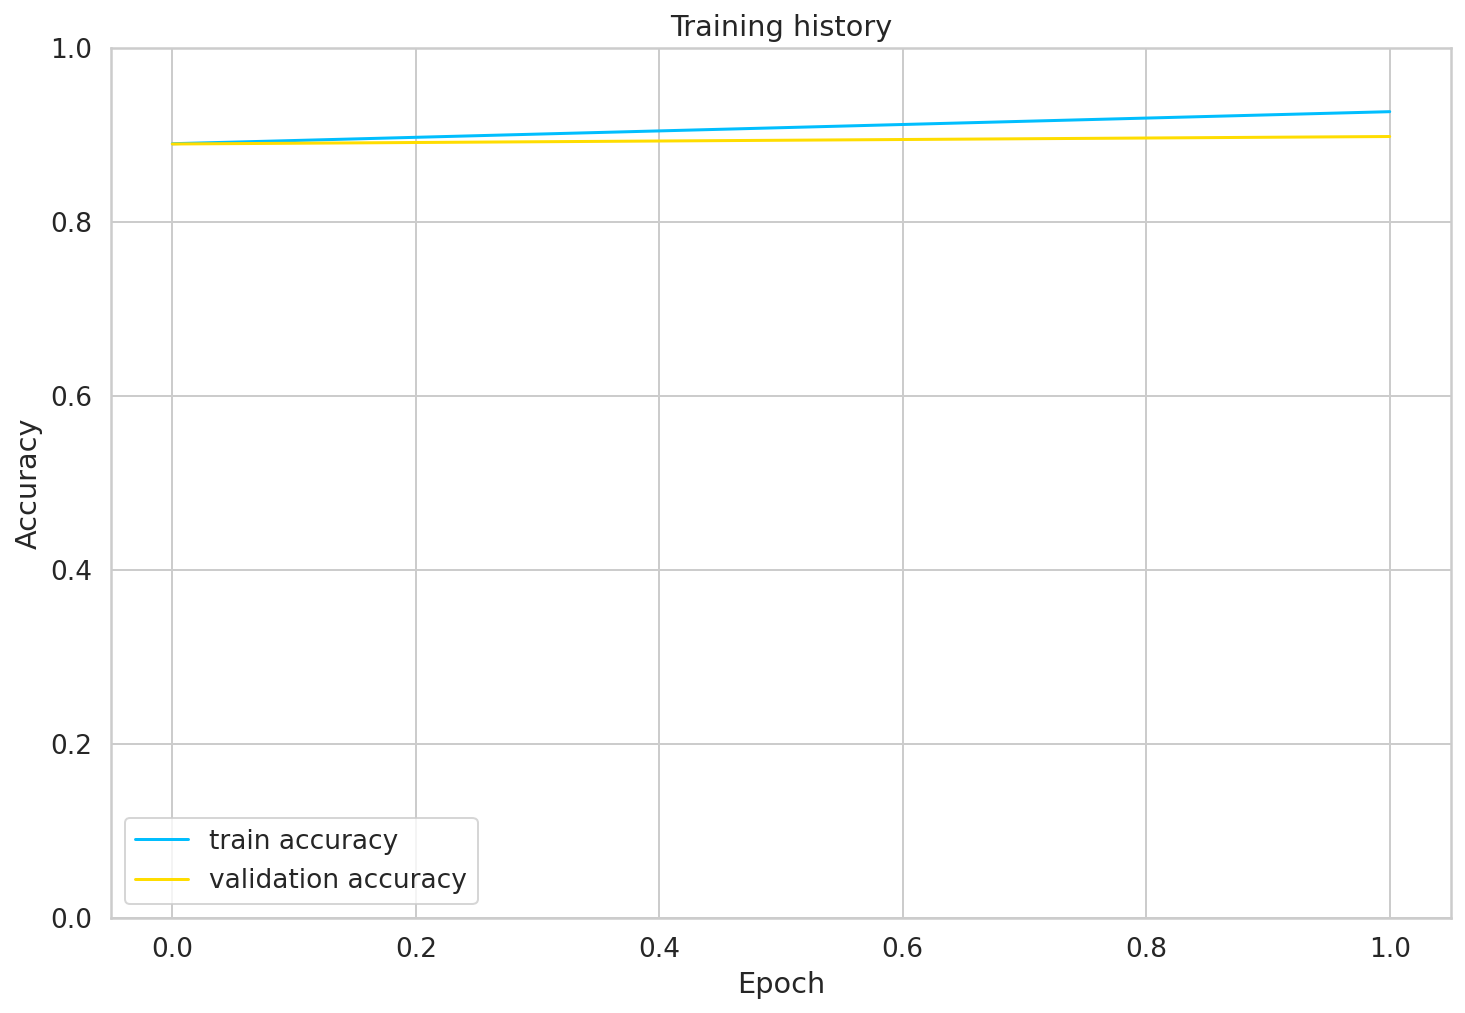

In [ ]:
plt.plot(history['train_acc'], label='train accuracy')
plt.plot(history['val_acc'], label='validation accuracy')
plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1])

# Evaluation

## Test metrics

In [ ]:
test_acc, _ = eval_model(
  model,
  test_data_loader,
  loss_fn,
  device,
  len(df_test)
)
test_acc.item()

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2232: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2232: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input si

0.8971454463072044

In [ ]:
def get_predictions(model, data_loader):
  model = model.eval()
  review_texts = []
  predictions = []
  prediction_probs = []
  real_values = []
  with torch.no_grad():
    for d in data_loader:
      texts = d["review_text"]
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)
      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )[0] # Add index 0 if we use Model_Rational_Label
      _, preds = torch.max(outputs, dim=1)
      review_texts.extend(texts)
      predictions.extend(preds)
      prediction_probs.extend(outputs)
      real_values.extend(targets)
  predictions = torch.stack(predictions).cpu()
  prediction_probs = torch.stack(prediction_probs).cpu()
  real_values = torch.stack(real_values).cpu()
  return review_texts, predictions, prediction_probs, real_values

In [ ]:
y_review_texts, y_pred, y_pred_probs, y_test = get_predictions(
  model,
  test_data_loader
)

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2232: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2232: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input si

In [ ]:
print(classification_report(y_test, y_pred, target_names=class_names))

                              precision    recall  f1-score   support

                 Hate Speech       0.75      0.72      0.73       437
Offensive or not Hate Speech       0.93      0.94      0.94      1770

                    accuracy                           0.90      2207
                   macro avg       0.84      0.83      0.84      2207
                weighted avg       0.90      0.90      0.90      2207



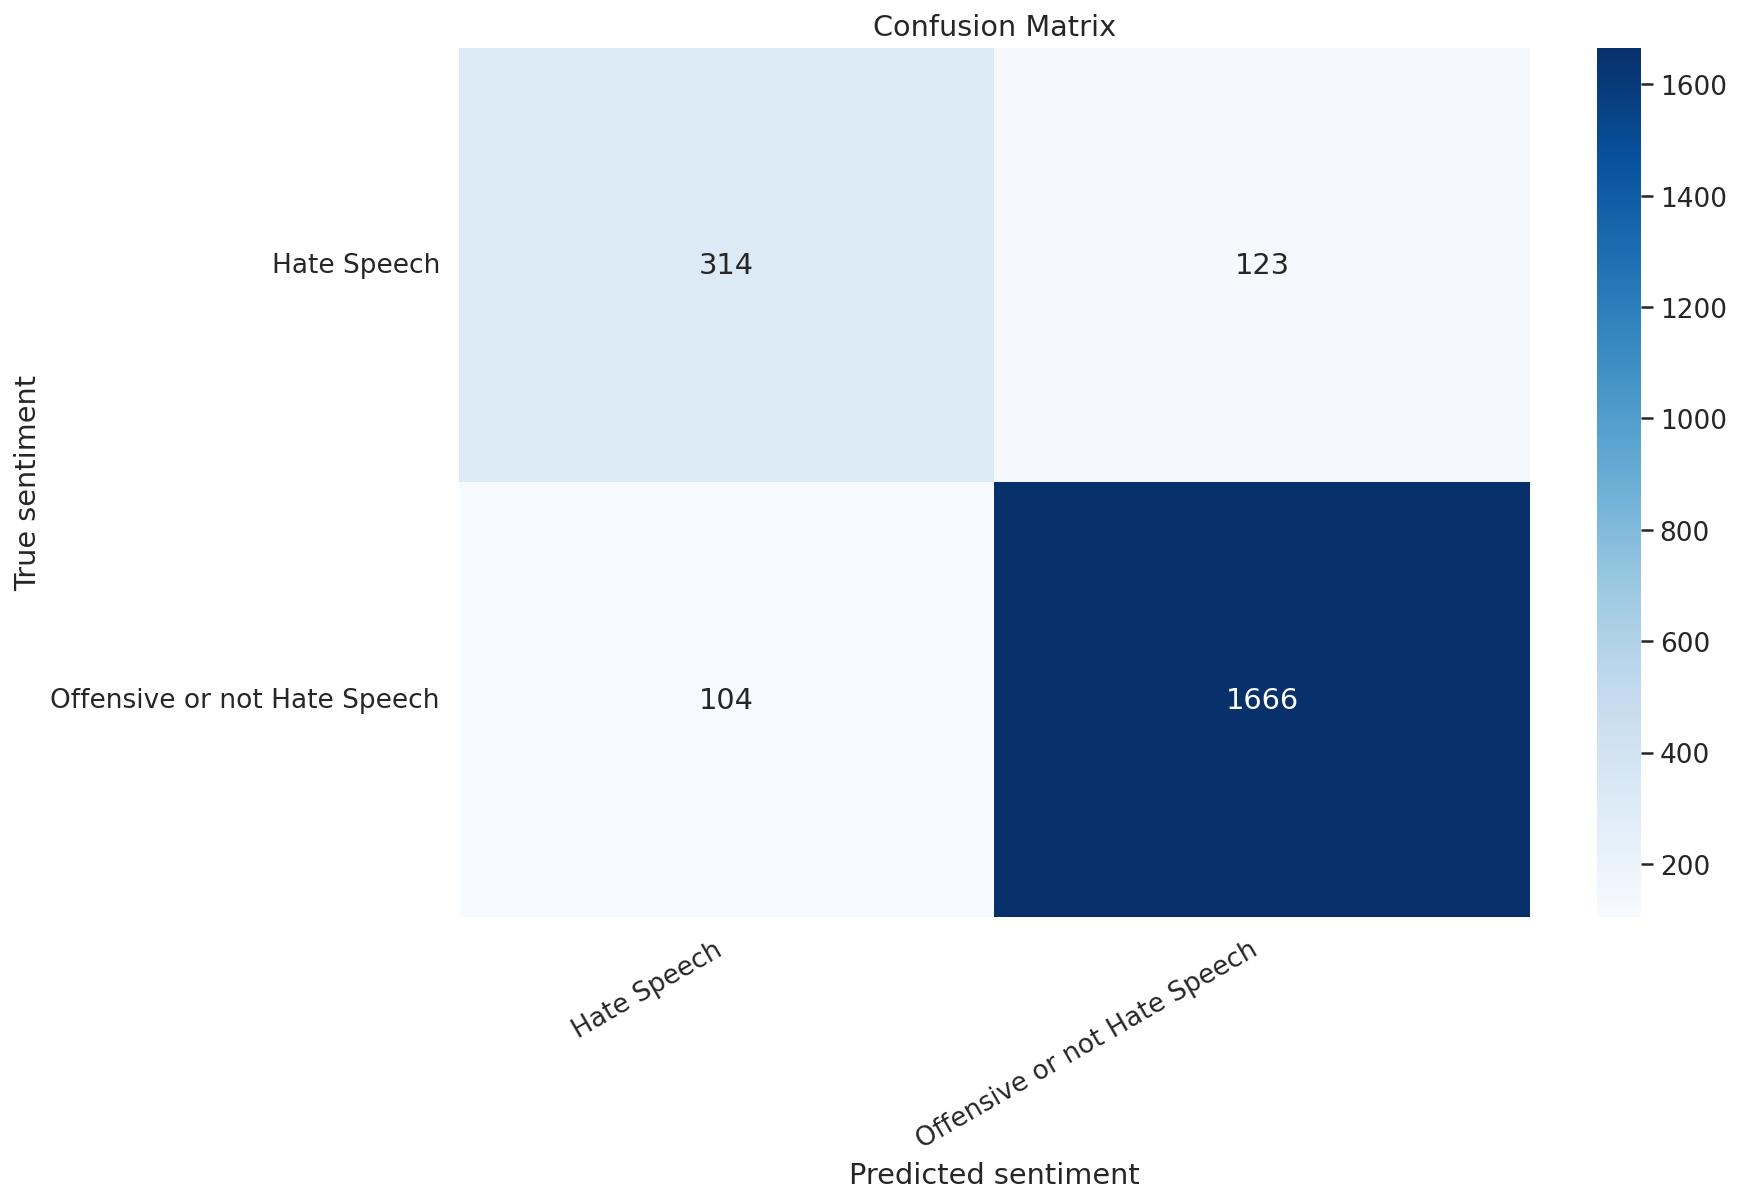

In [ ]:
def show_confusion_matrix(confusion_matrix):
  hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
  plt.ylabel('True sentiment')
  plt.xlabel('Predicted sentiment');
  plt.title('Confusion Matrix')
cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
show_confusion_matrix(df_cm)

## Tweets where we make errors

Here are the tweets which our model is not predicting correctly.

In [ ]:
for i in range(len(y_pred)):
   if(y_test[i] !=  y_pred[i]):
        print(y_review_texts[i])

celebrate curry go to let smash gay mongoloid fuck
user black black violence impossible white man whitey also move save save screw whitey
infidel islam worth tolerance understanding
oregon lose oregon ahhhahahaha faggot
say white like race support islam do not even think white band together enough white black asians hispanic need band together
say trump suppoer terrorist gun tote religious fundamentalist psychopath say
army republican welcome hate
imma get home around problem coon leave bar drank shot crown royal think still drive
love cripple look fucking cripple goddamit -PRON- be people person
user porch monkey banana suffice
opposed hillary -PRON- be shirt lift mongoloid
Laughing Out Loud sure deborah number nigger day leave
spic think someone
disability bigotry leave defend palin retard
elite looter try destroy history public school teach moslem invade europe help jewish traitor gate inquisition reparation jews sell white christians slave moslem
uhhh You stupid faggot goblin slaye

## Confidence in each sentiment

Text(0.5, 1.0, 'Prediction confidence for tweet ')

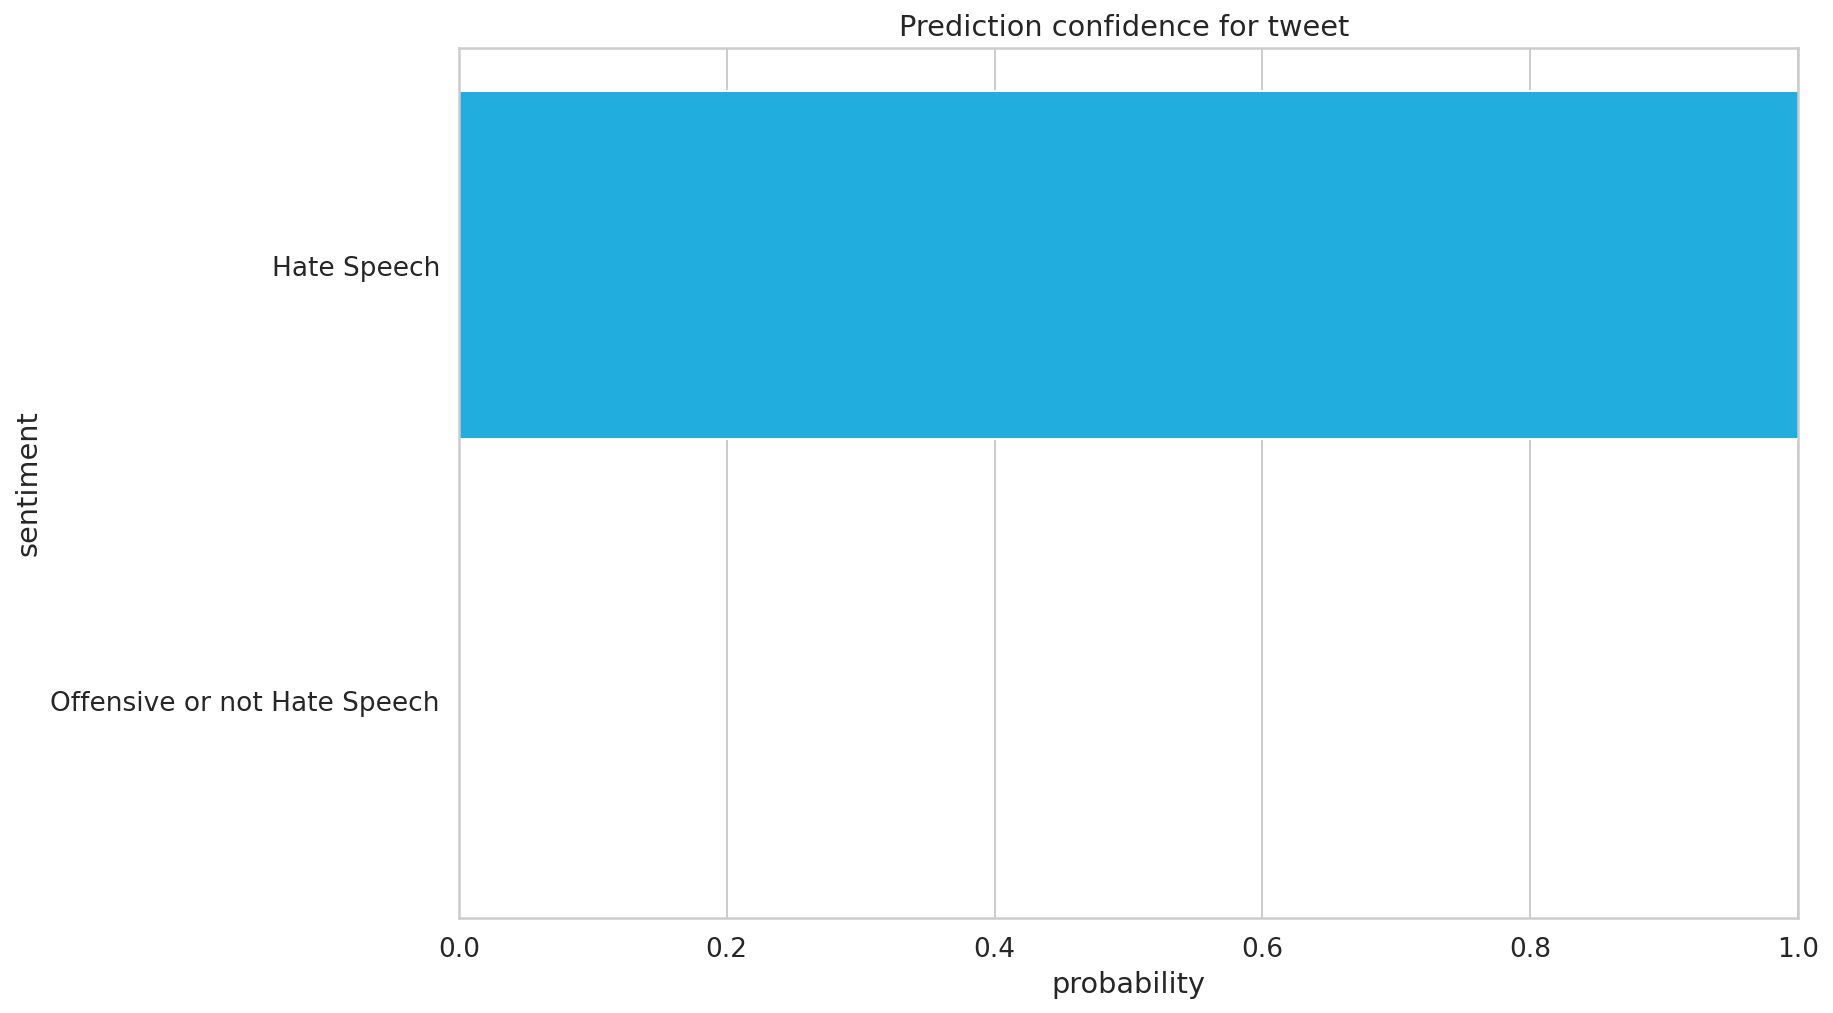

In [ ]:
idx = 16
review_text = y_review_texts[idx]
true_sentiment = y_test[idx]
pred_df = pd.DataFrame({
  'class_names': class_names,
  'values': y_pred_probs[idx]
})

sns.barplot(x='values', y='class_names', data=pred_df, orient='h')
plt.ylabel('sentiment')
plt.xlabel('probability')
plt.xlim([0, 1]);
plt.title("Prediction confidence for tweet ")

# Submission

In [ ]:
y_review_texts, y_pred, y_pred_probs, y_test = get_predictions(
  model,
  pred_data_loader
)

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2232: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2232: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input si

In [ ]:
submission_df = pd.DataFrame()
submission_df['text'] = test_df['text']
submission_df['sentiment'] = y_pred.detach().numpy()
PATH_TEST_SUBMISSION = 'drive/MyDrive/Hate Speech TikTok/submissions' 

submission_df.to_csv(f'{PATH_TEST_SUBMISSION}/predictions.csv', index=False)

# Bonus Task #TODO

## Sentiment Keyword Extraction

For the bonus task, we can estimate the overlap between our prediction, and the selected words ground truth using the Jaccard coefficient, which measures the ratio of intersection to union of predicted and label sets.

## Jaccard coefficient

In [ ]:
def jaccard(str1, str2): 
    a = set(str1.lower().split()) 
    b = set(str2.lower().split())
    c = a.intersection(b)
    return float(len(c)) / (len(a) + len(b) - len(c))